In [1]:
import os
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
import matplotlib.pyplot as plt
import seaborn as sns
from mne_connectivity import spectral_connectivity_time
from scipy.signal import savgol_filter  # Import Savitzky-Golay filter


In [2]:
path = r'C:\Users\than\OneDrive - wesleyan.edu\Documents - Melón Lab\Experiments\EXP240904'
data_dir = os.path.join(path, "iEEG_data")
output_dir = os.path.join(path, "results")  # Where to save results
os.makedirs(output_dir, exist_ok=True)  

In [4]:
# Define processing parameters
event_dict = {
    "Mouse In": 1,
    "EtOH Injected": 2,
    "Saline Injected": 2,
    "Juvenile In": 3
}
channels = ['EEG VTAA-B', 'EEG PFCA-B']  # Channels of interest
fmin, fmax = 1, 100  # Frequency range for PSD
sfreq = None  # Sampling frequency (to be set after loading data)
# Initialize a dictionary to hold DataFrames for each condition
psd_data = {condition: [] for condition in event_dict.keys()}
# Process each EDF file
edf_files = [f for f in os.listdir(data_dir) if f.endswith(".edf")]

In [5]:

for edf_file in edf_files:
    file_path = os.path.join(data_dir, edf_file)
    print(f"Processing {edf_file}...")

    # Load EDF file
    raw = mne.io.read_raw_edf(file_path, preload=True)
    if sfreq is None:
        sfreq = raw.info['sfreq']  # Set sampling frequency

    # Extract events
    events, _ = mne.events_from_annotations(raw, event_id=event_dict)
    # Notch filter to remove line noise (e.g., 60 Hz) 
    raw.notch_filter(freqs=[60], picks=channels)
    # Set EEG reference 
    raw.set_eeg_reference('average', projection=True) 
    # Filter data
    raw.filter(fmin, fmax, picks=channels)
    # Epoch the data for each condition
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=0, tmax=300, baseline=None, preload=True)

    for condition, event_id in event_dict.items():
        epochs_condition = epochs[condition]
        if len(epochs_condition) == 0:
            print(f"No valid epochs for {condition} in {edf_file}")
            continue

        # Compute PSD for each epoch
        psds = []
        for epoch in epochs_condition.get_data(picks=channels):
            psd, freqs = psd_array_multitaper(epoch, sfreq=sfreq, fmin=fmin, fmax=fmax, verbose=False)
            psds.append(psd)

        # Average PSD across epochs
        psds_mean = np.mean(psds, axis=0)

        # **Normalize PSD** (New Step!)
        psds_mean = psds_mean / np.mean(psds_mean, axis=1, keepdims=True)  # Normalized per channel

        # Create DataFrame
        df = pd.DataFrame(data=psds_mean.T, columns=channels)
        df['Frequency'] = freqs
        df['Mouse'] = edf_file
        df['Condition'] = condition

        # Append to the list for this condition
        psd_data[condition].append(df)

# Concatenate DataFrames for each condition
for condition in psd_data:
    psd_data[condition] = pd.concat(psd_data[condition], ignore_index=True)

# Save aggregated DataFrames
for condition, df in psd_data.items():
    df.to_csv(os.path.join(output_dir, f"{condition}_psd_data.csv"), index=False)

Processing 474_F_EtOH.edf...
Extracting EDF parameters from C:\Users\than\OneDrive - wesleyan.edu\Documents - Melón Lab\Experiments\EXP240904\iEEG_data\474_F_EtOH.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2239999  =      0.000 ...  2239.999 secs...
Used Annotations descriptions: [np.str_('EtOH Injected'), np.str_('Juvenile In'), np.str_('Mouse In')]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj meth

KeyboardInterrupt: 

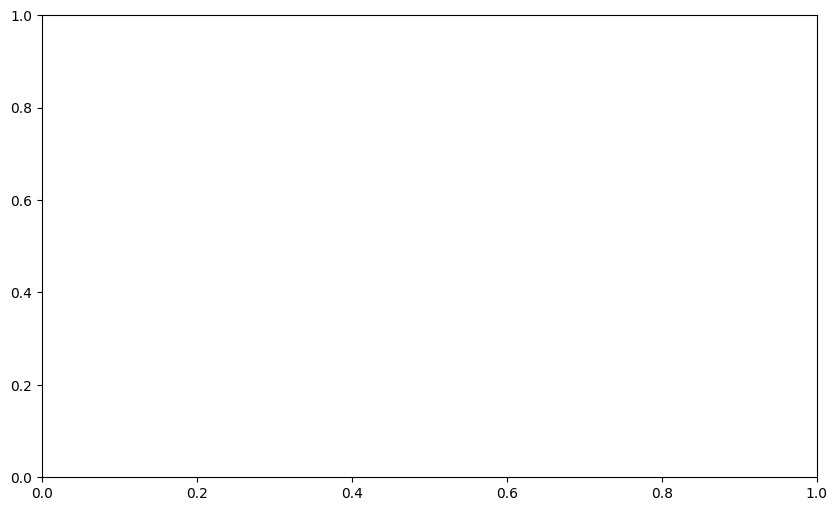

In [8]:
# Example: Plotting PSD for each condition
for condition, df in psd_data.items():
    # Melt the DataFrame for seaborn
    df_melted = df.melt(id_vars=['Frequency', 'Mouse', 'Condition'], value_vars=channels,
                        var_name='Channel', value_name='Power')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_melted, x='Frequency', y='Power', hue='Channel', estimator='mean')
    plt.xlim(0.5,10)
    plt.title(f"PSD - {condition}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB)")
    plt.legend(title='Channel')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f"{condition}_psd_plot.png"))
    plt.close()


In [ ]:
power_df['pmat'] = power_df['pmat'].apply(lambda pmat: pmat/np.mean(pmat))